In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 8
batch_size = 16
state_dim = 100
random_feature_dim = 1000
epochs = 10
n_obs = 8

num_desired_trajectories=20

# choose env from "random", "small world" or "dead ends"
env = GraphEnv(size=n_nodes, n_items=n_obs, env='random', batch_size=batch_size, num_desired_trajectories=num_desired_trajectories, unique = True)

dataset = RandomWalkDataset(env.adj_matrix, batch_size, num_desired_trajectories, n_obs)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

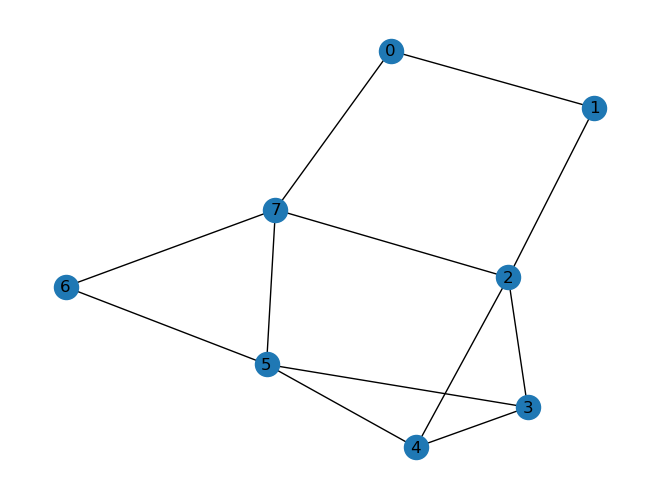

number of actions: 24
tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float))

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

# for trajectory in dataloader:
#     print(trajectory)
#     break

print(env.items)

In [4]:
# Our code
from trainer import POCMLTrainer
from model import POCML

model = POCML(n_obs = env.n_items,
                n_states = env.size,
                n_actions = env.n_actions,
                state_dim = state_dim,
                random_feature_dim = random_feature_dim)
    
trainer = POCMLTrainer(model=model, 
                       train_loader = dataloader,)

loss_record= trainer.train(epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

/home/zhuowen/project/GCML/model.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(self.beta * (phi_Q.conj().T @ state).real)
/home/zhuowen/project/GCML/model.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(self.beta * (phi_Q.conj().T @ state).real)


Text(0.5, 0, 'Number of weight updates')

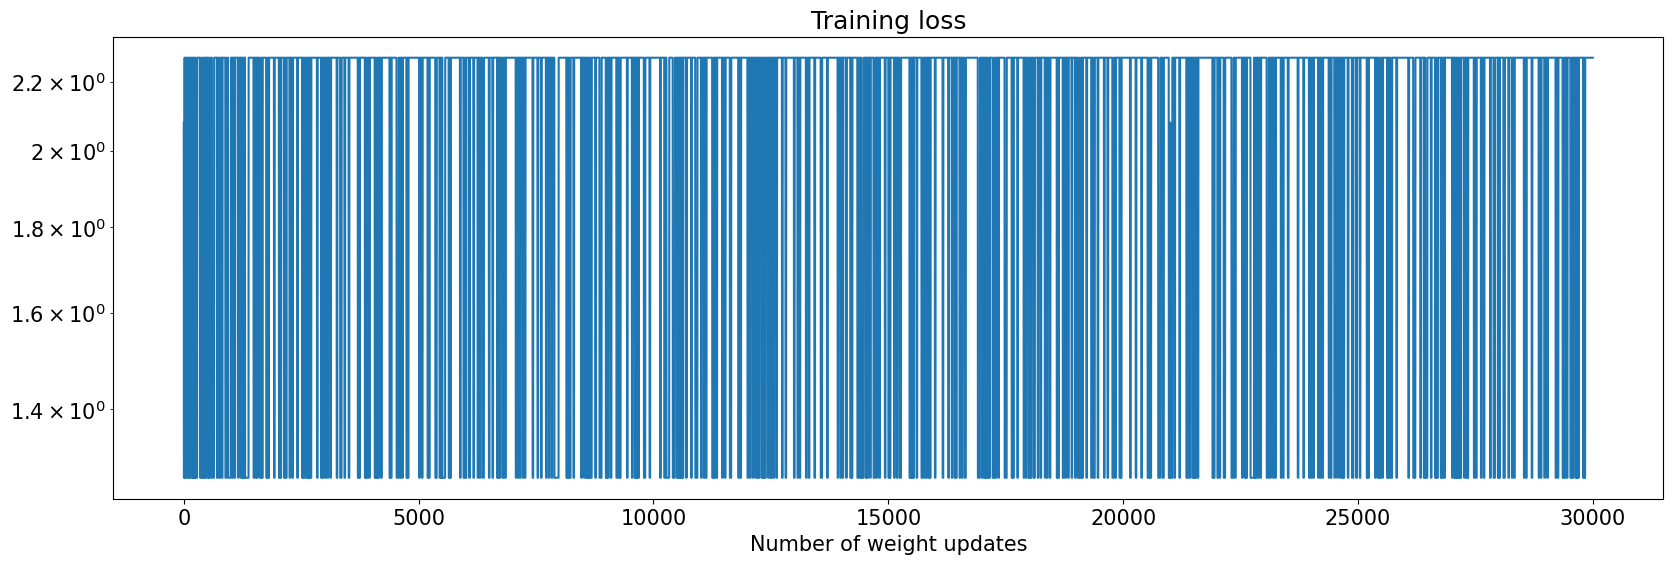

In [11]:
# our trainer loss plot

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record)
plt.yscale('log')
plt.title('Training loss')
plt.xlabel('Number of weight updates')

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 